In [1]:
import sqlite3
import glob
import pandas as pd

import sys
import os
parent_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(parent_dir)

# Now import directly from utils package
from utils.visual import draw_geo_ellipse, draw_center 
from utils.pca import generate_pca
import seaborn as sns
home = os.getcwd()
database_path = glob.glob(os.path.join(os.path.dirname(home),"page", "assets", "*.db"))[0]

In [2]:
# Conectar a la base de datos
conn = sqlite3.connect(database_path)

# Crear un cursor para interactuar con la base de datos
cursor = conn.cursor()

# Verificar que la conexión se realizó correctamente
print(f"Conexión exitosa a la base de datos: {database_path}")

Conexión exitosa a la base de datos: c:\Users\WilhelmB\Documents\-Complementariedad-Energetica\page\assets\climate_data.db


In [3]:
# Ejecutar la consulta para obtener los datos de la tabla 'locations'
cursor.execute("SELECT * FROM locations")

# Obtener los nombres de las columnas
columns = [description[0] for description in cursor.description]

# Convertir los resultados a un DataFrame
locations_df = pd.DataFrame(cursor.fetchall(), columns=columns)

# Mostrar el DataFrame
locations_df = locations_df.drop(columns=['name'])
locations_df = locations_df.rename(columns={'latitude': 'lat', 'longitude': 'lon'})
print(locations_df)

     location_id    lat    lon
0              1  11.71 -72.26
1              2  11.38 -72.24
2              3  11.25 -74.21
3              4   6.31 -73.94
4              5  10.16 -73.95
..           ...    ...    ...
348          349   5.96 -75.09
349          350   6.10 -73.44
350          351   5.65 -75.88
351          352   5.63 -72.42
352          353   4.86 -73.26

[353 rows x 3 columns]


In [4]:
cursor.execute("SELECT * FROM TypicalMonth")
columns = [description[0] for description in cursor.description]

# Convertir los resultados a un DataFrame
climate_df = pd.DataFrame(cursor.fetchall(), columns=columns)
climate_df = climate_df.drop(columns=['record_id'])
climate_df = climate_df.drop(columns=['temperature'])
monthly_avg = climate_df.groupby(['location_id', 'month']).agg({
    'ghi': 'mean',
    'wind_speed': 'mean'
}).reset_index()
merged_df = pd.merge(monthly_avg, locations_df, on='location_id')


In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from math import radians, cos, sin, asin, sqrt
from matplotlib.patches import Circle
# === 1. Simulación de datos === #
#np.random.seed(42)
df = merged_df.copy()
# === 2. Vector climatológico por localización === #
agg = df.groupby('location_id').agg({
    'ghi': ['mean', 'std', 'max'],
    'wind_speed': ['mean', 'std','max'],
    'lat': 'first',
    'lon': 'first'
}).reset_index()

agg.columns = ['location_id', 'ghi_mean', 'ghi_std','ghi_max', 'wind_mean', 'wind_std','wind_max' ,'lat', 'lon']
climate_features = agg[['ghi_mean', 'ghi_std','ghi_max', 'wind_mean', 'wind_std','wind_max']].values

# === 3. Distancia geodésica entre coordenadas (Haversine) === #
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return 2 * R * asin(sqrt(a))

coords = agg[['lat', 'lon']].values
n = len(coords)
geo_dists = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        geo_dists[i, j] = haversine(coords[i][0], coords[i][1], coords[j][0], coords[j][1])

# === 4. Distancia climatológica === #
scaler = StandardScaler()
climate_scaled = scaler.fit_transform(climate_features)
clim_dists = pairwise_distances(climate_scaled, metric='euclidean')

# === 5. Distancia híbrida: α * D_geo + (1-α) * D_clim === #
alpha = 0.2
D_total = alpha * geo_dists + (1 - alpha) * clim_dists

# === 6. Clustering jerárquico === #
hierarchical = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
labels_hier = hierarchical.fit_predict(D_total)
score = silhouette_score(D_total, labels_hier, metric='precomputed')
print(f"Clustering jerárquico con Silhouette Score={score:.3f}")


Clustering jerárquico con Silhouette Score=0.269


In [29]:
agg['cluster'] = labels_hier
dic = agg[["location_id","cluster"]]
corr = pd.read_csv("../page/assets/P2/correlation_matrix_typical.csv",index_col=0)
clusters = dic["cluster"].unique()
clusters.sort()

cluster_corr = np.zeros((len(clusters), len(clusters)))

for i, ci in enumerate(clusters):
    idx_radiancia = dic[dic["cluster"] == ci]["location_id"].values - 1
    for j, cj in enumerate(clusters):
        ubicaciones_j = dic[dic["cluster"] == cj]["location_id"].values  -1  # por ejemplo: ["GHI_2", "GHI_3"]
        #print(j)
        submatrix = corr.iloc[idx_radiancia, ubicaciones_j]
        #print(cluster_corr)
        cluster_corr[i, j] = submatrix.to_numpy().mean()

df_cluster_corr = pd.DataFrame(cluster_corr,index=[f'GHI_{id}' for id in clusters], columns=[f'Wind_Speed_{id}' for id in clusters])

In [30]:
agg['cluster_hier'] = labels_hier
cluster_means = agg.groupby('cluster_hier')[['ghi_mean','ghi_std','ghi_max','wind_mean','wind_std','wind_max', 'lat', 'lon']].mean()
cluster_means

,ghi_mean,ghi_std,ghi_max,wind_mean,wind_std,wind_max,lat,lon
cluster_hier,,,,,,,,
0,207.792598,18.134401,240.679987,0.785831,0.149502,1.069493,5.443613,-74.299319
1,211.173552,26.464021,251.812602,1.407535,0.451236,2.208656,5.828750,-70.927500
2,201.436019,15.098089,226.719108,1.174941,0.266185,1.679272,2.690000,-76.070000
3,208.849330,16.651153,239.432276,0.331682,0.065295,0.459422,7.670870,-75.656522
4,247.236555,17.578908,276.271237,1.796261,0.283062,2.150843,11.051000,-72.786000
5,208.965312,26.252194,243.639881,0.156877,0.027777,0.199194,3.870000,-67.920000
6,230.323152,20.841473,264.557176,1.520261,0.421065,2.259322,10.007231,-74.989385
7,193.422041,16.281270,220.354167,0.272680,0.017422,0.303226,-4.210000,-69.940000
8,191.619236,18.554555,215.435484,0.143510,0.016331,0.178763,1.270000,-70.240000


In [31]:
data_frames = []
for i, ci in enumerate(clusters):
    idx = (dic[dic["cluster"] == ci]["location_id"].values - 1).tolist()  # Convertir a lista de índices
    cursor.execute("SELECT * FROM TypicalMonth WHERE location_id IN ({})".format(','.join('?' for _ in idx)), idx)
    columns = [description[0] for description in cursor.description]

    climate_df = pd.DataFrame(cursor.fetchall(), columns=columns)

    cols_to_group = ['month', 'day', 'hour', 'minute']
    variables_to_avg = ['ghi', 'wind_speed', 'temperature']

    df_result = climate_df.groupby(cols_to_group)[variables_to_avg].mean().reset_index()
    data_frames.append(df_result[['ghi', 'wind_speed']].rename(columns={'ghi': f'ghi_{ci}', 'wind_speed': f'wind_speed_{ci}'}))
combined_data = pd.concat(data_frames, axis=1)

correlation_data = []

# GHI of each location against Wind Speed of every other location
for ghi_id in clusters:
    row = []
    for wind_id in clusters:
        ghi_col = f'ghi_{ghi_id}'
        wind_col = f'wind_speed_{wind_id}'
        correlation = combined_data[ghi_col].corr(combined_data[wind_col])
        row.append(correlation)
    correlation_data.append(row)

correlation_matrix = pd.DataFrame(correlation_data, index=[f'GHI_{id}' for id in clusters], columns=[f'Wind_Speed_{id}' for id in clusters])

C:\Users\WilhelmB\AppData\Local\Temp\ipykernel_12572\2355133413.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


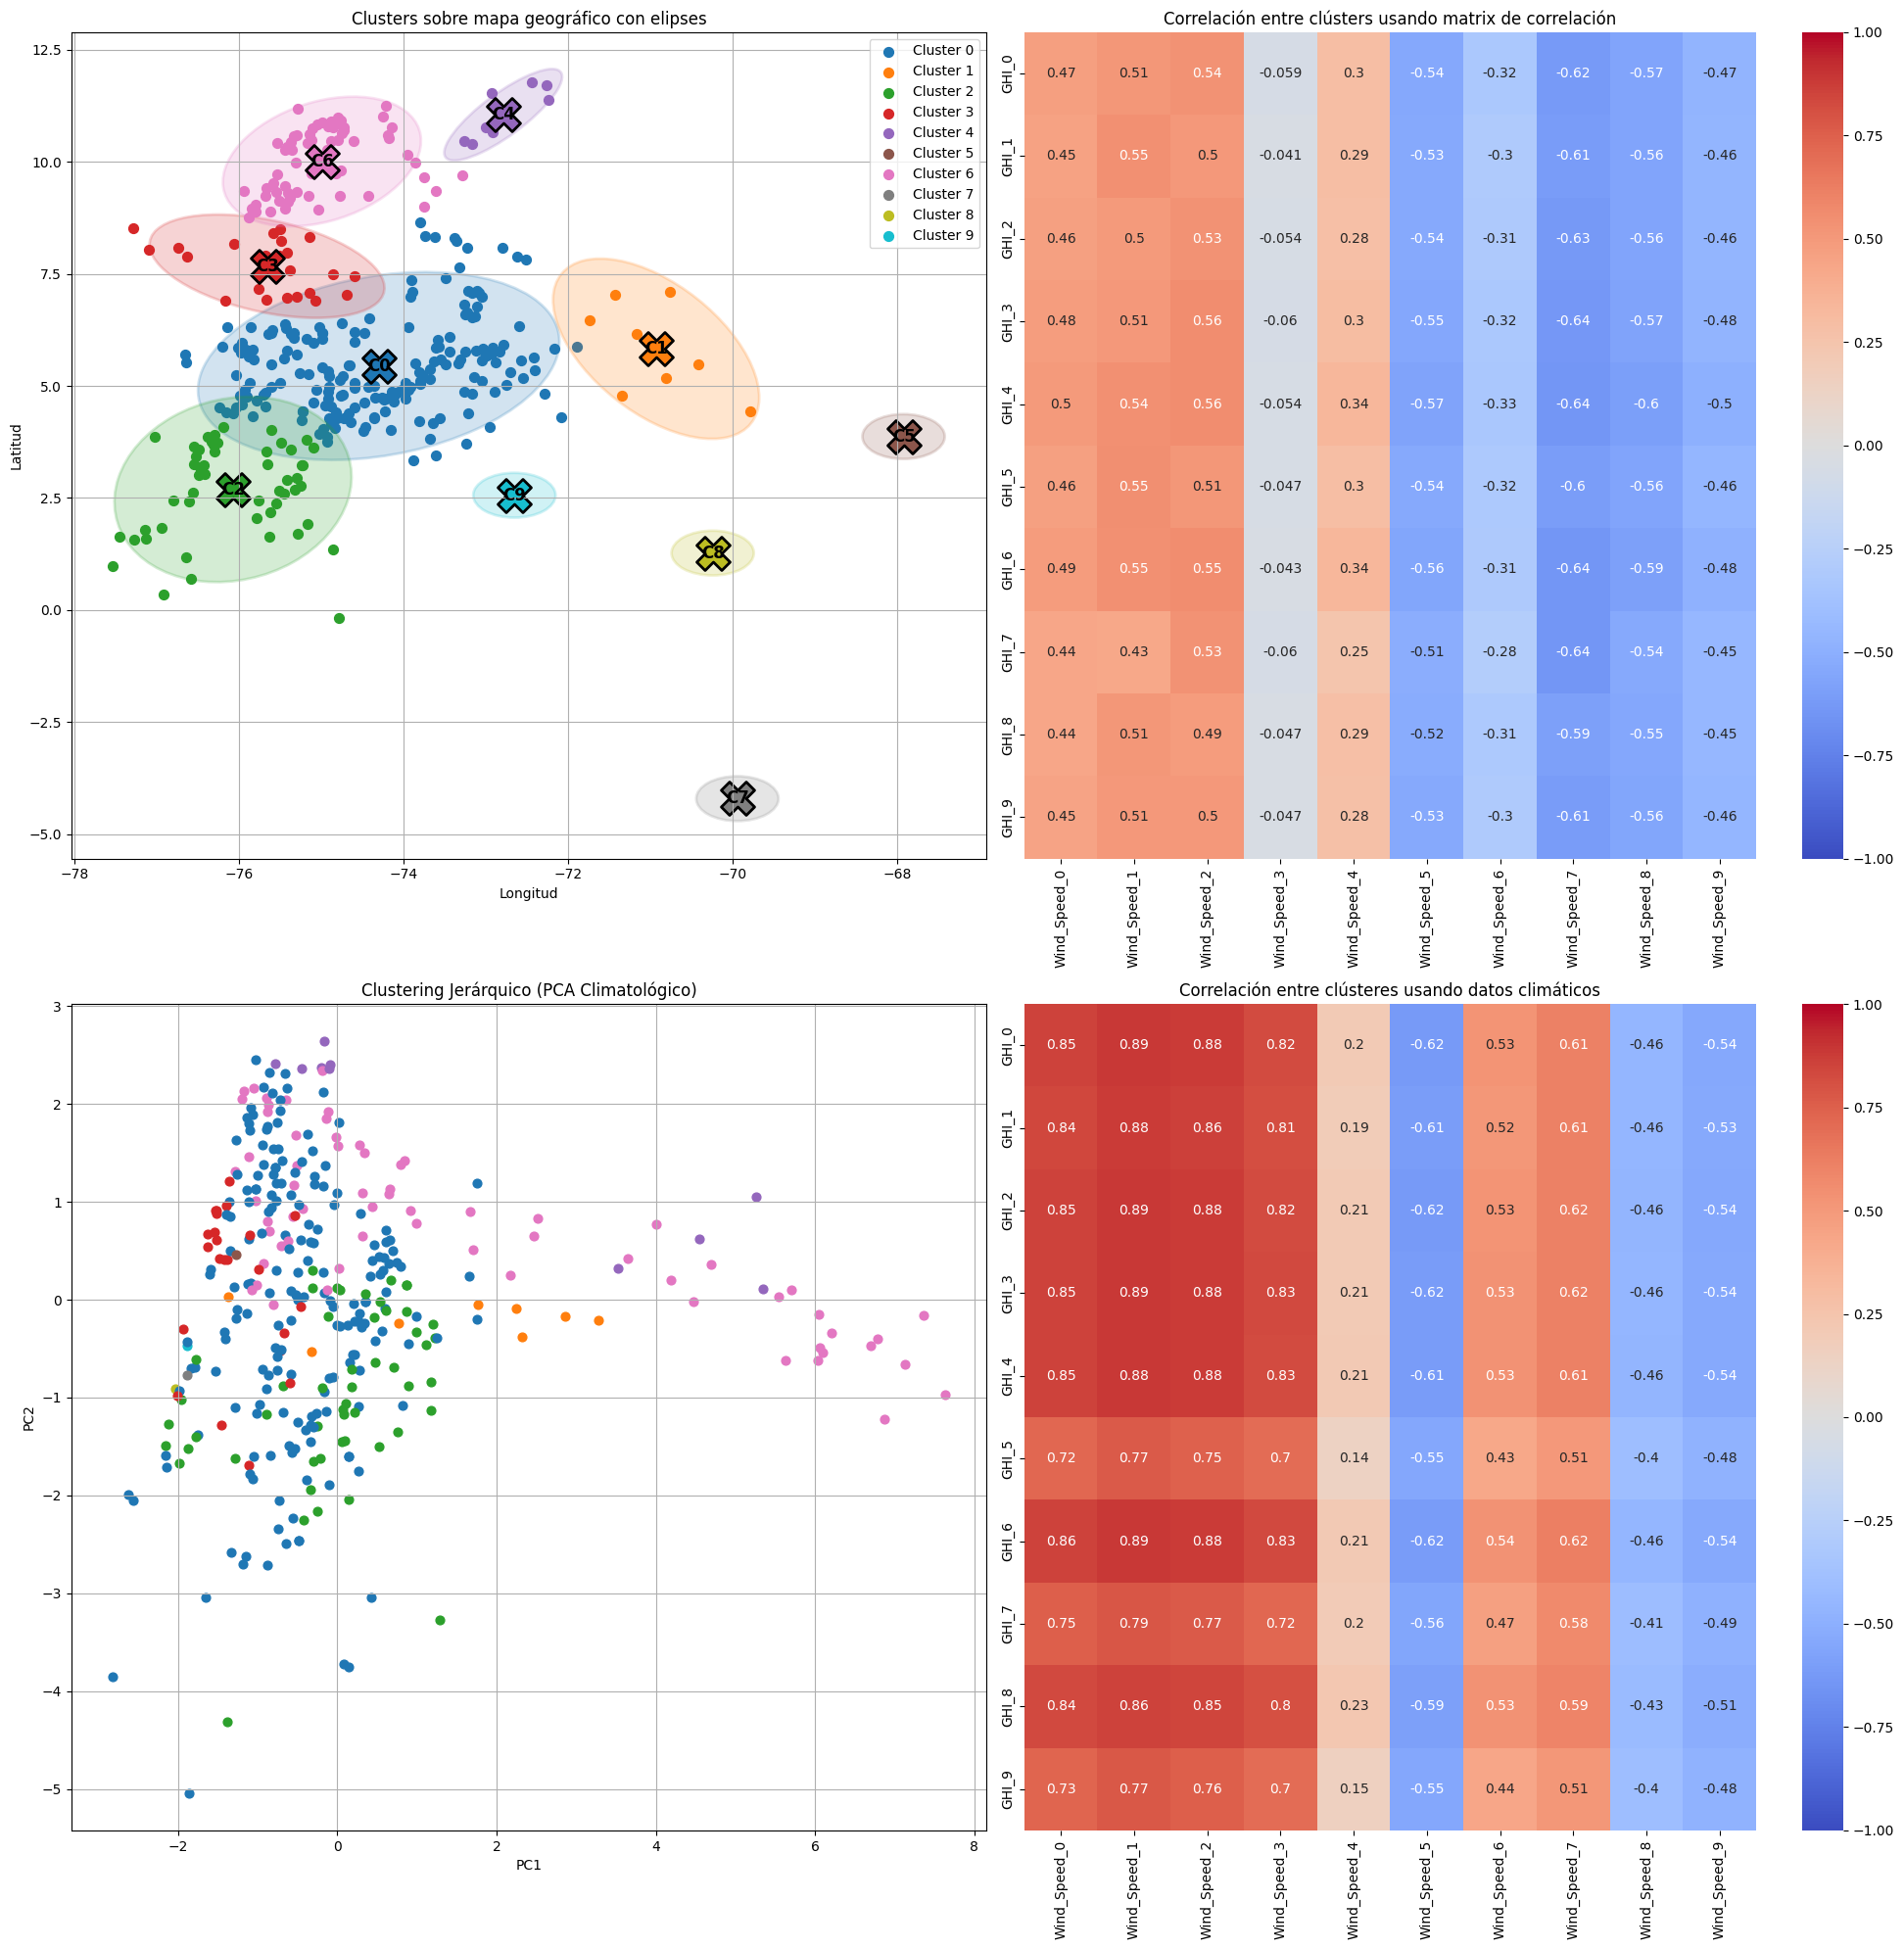

In [32]:
clusters = dic["cluster"].unique()
clusters.sort()

fig, ax = plt.subplots(2,2, figsize=(20,20))
unique_labels = np.unique(labels_hier)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    cluster_coords = coords[labels_hier == label]
    color = colors(i)
    draw_geo_ellipse(ax[0,0], cluster_coords, color=color, label=f'Cluster {label}')
    draw_center(ax[0,0],coords=cluster_coords,color=color,cluster_id = label)
ax[0,0].set_title("Clusters sobre mapa geográfico con elipses")
ax[0,0].set_xlabel("Longitud")
ax[0,0].set_ylabel("Latitud")
ax[0,0].legend()
ax[0,0].grid(True)

generate_pca(ax = ax[1,0], 
             n_components=2,
             data = climate_scaled, 
             dimensions = [0,1], 
             labels = labels_hier)


sns.heatmap(df_cluster_corr, annot=True, cmap='coolwarm', center=0, ax=ax[0,1],vmin=-1, vmax=1)
ax[0,1].set_title("Correlación entre clústers usando matrix de correlación")

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax[1,1],vmin=-1, vmax=1)
ax[1,1].set_title("Correlación entre clústeres usando datos climáticos")

plt.tight_layout()
plt.show()